# **TP06 - Árboles de decisión**

<p align=center>
    <img src="https://github.com/walteraguirre/TPS/blob/main/TP06/imagenes/enunciado.png?raw=true" alt="enunciado">
</p>

In [23]:
#librerias
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import _tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import resample
from scipy.stats import mode

In [24]:
# Cargamos el dataset
wine = load_wine()

#separamos los datos y las etiquetas
X = wine.data
y = wine.target

#obtenemos los nombres de los features y de las clases 
feature_names = wine.feature_names
target_names = wine.target_names

#===============================================================#
# lo de abajo lo hago para visualizar los datos de alguna forma

# Convertimos a DataFrame para facilitar la exploración
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Primeras filas y resumen estadístico
print(df.head().to_markdown())

print('\n')

# Ver distribución de clases
print(df['target'].value_counts())


|    |   alcohol |   malic_acid |   ash |   alcalinity_of_ash |   magnesium |   total_phenols |   flavanoids |   nonflavanoid_phenols |   proanthocyanins |   color_intensity |   hue |   od280/od315_of_diluted_wines |   proline |   target |
|---:|----------:|-------------:|------:|--------------------:|------------:|----------------:|-------------:|-----------------------:|------------------:|------------------:|------:|-------------------------------:|----------:|---------:|
|  0 |     14.23 |         1.71 |  2.43 |                15.6 |         127 |            2.8  |         3.06 |                   0.28 |              2.29 |              5.64 |  1.04 |                           3.92 |      1065 |        0 |
|  1 |     13.2  |         1.78 |  2.14 |                11.2 |         100 |            2.65 |         2.76 |                   0.26 |              1.28 |              4.38 |  1.05 |                           3.4  |      1050 |        0 |
|  2 |     13.16 |         2.36 |  2.67 

Se puede observar las primeras 5 muestras dentro del dataset, en las mismas se observa que cada muestra presentan varias características que luego van a ser utilizadas por los algoritmos de árboles de decisión para poder determinar de a que productor de vino corresponde una muestra.

También se muestran la cantidad de muestras asociadas a cada productor, siendo el productor 1 el que mayor cantidad de muestras presenta en el dataset.

---

## Árboles de Decisión CART

Los árboles de decisión son modelos predictivos que se utilizan en el campo del aprendizaje automático y la estadística. Su estructura en forma de árbol permite representar de manera intuitiva un conjunto de reglas de decisión basadas en las características de los datos. El método CART (Classification and Regression Trees), es una técnica específica para la construcción de árboles de decisión que puede aplicarse tanto a problemas de clasificación como de regresión.

Los elementos de un árbol de decisión CART son:

- Nodo raíz: Es el punto de partida del árbol, donde se realiza la primera división de los datos.
- Nodos internos: Representan decisiones basadas en condiciones sobre las variables predictoras.
- Ramas: Conectan los nodos y representan los resultados de las decisiones.
- Nodos hoja: Corresponden a las salidas finales del modelo. En clasificación, contienen una clase; en regresión, un valor numérico estimado.

El método CART construye el árbol mediante un proceso recursivo de división binaria. Para cada división, se selecciona la variable y el punto de corte que mejor separan los datos, según un criterio de impureza o error:

- En clasificación, se utiliza típicamente el índice de Gini o la entropía para medir la pureza de los nodos.
- En regresión, se minimiza el error cuadrático medio (MSE).

El proceso continúa hasta que se cumple alguna condición de parada como:
- Todas las observaciones tienen la misma etiqueta.
- Si la rama tiene menos de un número preestablecido de observaciones.

---

### Modelado matemático por nodo

Para formalizar el proceso de construcción del árbol, se puede utilizar el siguiente modelo matemático por nodo:

Llamamos:

- $ Q_m $ al conjunto de datos en el nodo $ m $.
- $ Q_m^L(j_m, t_m) = \{ (x, y) \in Q_m : x_{j_m} \leq t_m \} $.
- $ Q_m^R(j_m, t_m) = \{ (x, y) \in Q_m : x_{j_m} > t_m \} $.
- $ H(Q_m) $ a la función impureza del conjunto $ Q_m $.
- $ G_m(j_m, t_m) = \frac{|Q_m^L(j_m, t_m)|}{|Q_m|} H(Q_m^L(j_m, t_m)) + \frac{|Q_m^R(j_m, t_m)|}{|Q_m|} H(Q_m^R(j_m, t_m)) $.
- Se selecciona la mejor división buscando $ (j_m^*, t_m^*) = \arg \min_{j_m, t_m} G_m(j_m, t_m) $.

Este enfoque permite construir árboles óptimos localmente, eligiendo en cada nodo la división que minimiza la impureza ponderada de los subconjuntos hijos.

En este trabajo, dado que se quiere clasificar el productor del cual proviene el vino, vamos a utilizar el método con las funciones de impurezas adecuadas para un problema de clasificación.

En un nodo $ m $, que representa una región $ R_m $ con $ N_m $ observaciones, la proporción de observaciones de clase $ k $ se define como:

$$
\hat{p}_{mk} = \frac{1}{N_m} \sum_{x_i \in R_m} I(y_i = k)
$$

Donde $ I(y_i = k) $ es la función indicadora que vale 1 si la observación $ y_i $ pertenece a la clase $ k $, y 0 en caso contrario.

A partir de esto, se pueden definir diferentes funciones de impureza $ H_m(T) $ para clasificación:

- **Índice de Gini (Gini index):**

$$
\text{Gini} = \sum_{k \ne k'} \hat{p}_{mk} \hat{p}_{mk'} = \sum_{k=1}^K \hat{p}_{mk} (1 - \hat{p}_{mk})
$$

- **Entropía Cruzada (Cross-entropy):**

$$
\text{Entropía} = -\sum_{k=1}^K \hat{p}_{mk} \log_2 (\hat{p}_{mk})
$$


El índice de Gini mide cuán probable es que una observación seleccionada al azar sea mal clasificada, asumiendo que se la clasifica aleatoriamente según la distribución de clases del nodo. Un nodo completamente puro (todas las observaciones pertenecen a la misma clase) tiene un índice de Gini igual a 0. A medida que el nodo contiene una mezcla más balanceada de clases, el valor del índice aumenta. El índice de Gini es eficiente computacionalmente.

Por otro lado, la entropía cruzada, mide el grado de desorden o incertidumbre de las clases en un nodo. También alcanza un valor de 0 cuando el nodo es puro, pero penaliza más fuertemente las distribuciones con clases poco frecuentes. Es decir, es más sensible que el índice de Gini a los cambios en la distribución de clases. La entropía cruzada tiende a generar divisiones más equilibradas cuando hay clases poco representadas.

---

### **Implementación**

Para poder implementar el árbol de decisión, vamos a utilizar `DecisionTreeClassifier` de la librería `sklearn`. Para este modelo queremos utilizar como función de impurezas, la entropía cruzada, por lo tanto, a la hora de inicializar la clase. debemos setear el párametro `criterion = "entropy"`.

Una vez que tenemos el modelo, lo entrenamos con el método `fit` pasando como argumento los datos `X` y las etiquetas `y`.

Para graficar el diagrama de árbol, utilizamos el método `plot_tree`, pasando como argumentos, el modelo, los nombres de los features y los nombres de las clases.

Luego con `clf.tree_.node_count` podemos obtener la cantidad de nodos del árbol; y con `sum(clf.tree_.children_left == -1)` podemos obtener la cantidad de hojas del árbol (los nodos tiene un atributo `children_left` y `children_right`, cuando un nodo es "hoja", ambos atributos valen `-1` ).

Para identificar las variables más relevantes en la clasificación, se utilizó el atributo `feature_importances_` del clasificador entrenado. Este vector indica la importancia relativa de cada atributo, basada en la cantidad de veces que fue utilizado para dividir nodos y la reducción total de entropía que generó. Se seleccionaron las tres características con mayor importancia, que representan aquellas que más contribuyeron a la separación de clases en el árbol de decisión.

Por último, a partir de una nueva muestra, se quiere predecir a que productor de vino corresponde.

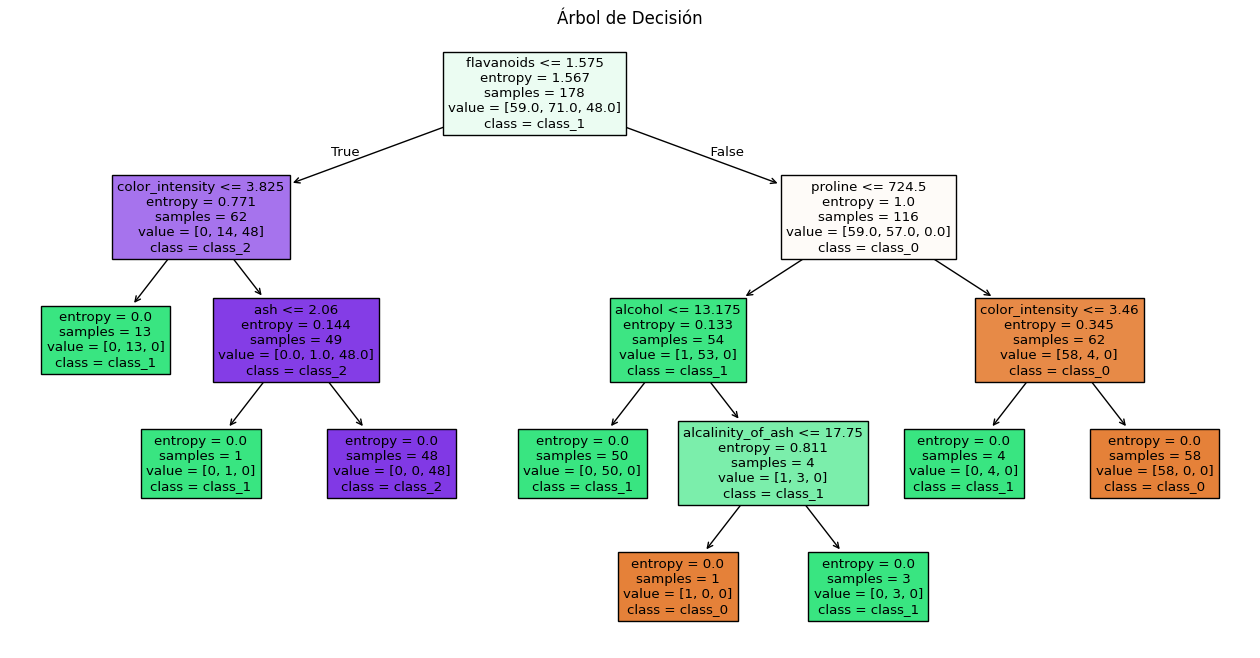

Número total de nodos: 15
Número total de hojas: 8
Top 3 características más importantes:
- flavanoids: 0.4128
- proline: 0.3134
- color_intensity: 0.2228

La muestra fue clasificada como clase: class_0


In [25]:
# generamos y entrenamos el árbol de decisión con criterio "entropy"
clf = DecisionTreeClassifier(criterion="entropy")
clf.fit(X, y)

# Graficamos el árbol
plt.figure(figsize=(16, 8))
plot_tree(clf, filled=True, feature_names=feature_names, class_names=target_names)
plt.title("Árbol de Decisión")
plt.show()

#obtenemos la cantidad de nodos y hojas
n_nodos = clf.tree_.node_count
n_hojas = sum(clf.tree_.children_left == -1)
print(f"Número total de nodos: {n_nodos}")
print(f"Número total de hojas: {n_hojas}")

#  Mostramos las 3 características más importantes
importances = clf.feature_importances_
top_indices = np.argsort(importances)[::-1][:3]  # índices de las 3 más importantes

print("Top 3 características más importantes:")
for idx in top_indices:
    print(f"- {feature_names[idx]}: {importances[idx]:.4f}")

# Clasificamos la nueva muestra
muestra = np.array([[13.0, 2.33, 2.37, 19.5, 99.7, 2.29, 2.03, 0.36, 1.59, 5.06, 0.96, 2.61, 747]])
prediccion = clf.predict(muestra)
print(f"\nLa muestra fue clasificada como clase: {target_names[prediccion[0]]}")


En el gráfico se puede ver el árbol obtenido, en el cual se observa:

- 15 nodos en total.  
- 8 hojas.

Dada la profundidad del árbol y que varios nodos terminales presentan entropía 0, se puede decir que el árbol se adaptó muy bien a los datos de entrenamiento. Sin embargo, esto también podría ser indicio de **overfitting**, lo que afectaría negativamente su capacidad de generalizar sobre nuevos datos. Además, se observan nodos terminales con una sola muestra, lo cual es una señal típica de sobreajuste.

Por otro lado, las tres características más importantes para la clasificación corresponden al nodo raíz (`flavanoids`) y a los dos nodos que lo siguen (`proline` y `color_intensity`). Estas variables muestran mayor capacidad para discriminar entre clases, y son las más utilizadas por el árbol para dividir los datos.


---

## **Árbol podado**

Un árbol podado es una versión simplificada de un árbol de decisión que ha sido reducido mediante la eliminación de ramas que aportan poca o ninguna mejora en la capacidad predictiva del modelo. El objetivo principal de la poda es evitar el overfitting, que ocurre cuando el árbol se adapta demasiado a los datos de entrenamiento, perdiendo capacidad de generalización.

La técnica de poda que vamos a utilizar en nuestro caso es la poda basada en costo-complejidad, empleada por el algoritmo CART. Esta técnica evalúa un conjunto de árboles podados mediante una función de costo definida como:

$$
H_\alpha(T) = \sum_{m \in L(T)} \frac{|Q_m|}{n} \cdot H(Q_m) + \alpha \cdot |L(T)|
$$

Donde:
- $ |Q_m| $ es la cantidad de muestras en la hoja $ m $,
- $ n $ es el número total de observaciones,
- $ H(Q_m) $ es la medida de impureza del nodo $ m $ (como entropía o índice de Gini),
- $ |L(T)| $ es el número total de hojas del árbol.



La poda se realiza seleccionando el subárbol que minimiza esta medida, logrando así un compromiso entre el ajuste a los datos (primer término) y la simplicidad del modelo (segundo término penalizado por $ \alpha $).

---

### **Implementación**

Para implementar el árbol de decisión podado, vamos a utilizar nuevamente `DecisionTreeClassifier` con entropía cruzada como función de impurezas y con un `alpha` de $0.05$ (para ello se setea el parámetro `cpp_alpha = 0.05`).

Luego se realiza lo mismo que para el caso anterior (entrenar el modelo, graficar el árbol, informar la cantidad de hojas y nodos, predecir la muestra).


Por último, para poder calcular el costo complejidad, lo que se hace es iterar sobre todos los nodos:

- Si el nodo no es una hoja, no se realiza nada.

- Si el nodo es una hoja, obtenemos la cantidad de muestras de $Q_m$ correspondientes a la hoja ($n_m$ en la implementación) y la impureza $H(Q_m)$ en la misma. Con estos datos vamos realizando la suma ponderada correspondiente al primer termino de la función de costo-complejidad mencionada previamente, es decir, el término:

$$
\sum_{m \in L(T)} \frac{|Q_m|}{n} \cdot H(Q_m)
$$

Luego con el valor del parámetro $\alpha$ utilizado y sabiendo la cantidad de hojas del árbol, terminamos de calcular la función costo complejidad:


$$
H_\alpha(T) = \sum_{m \in L(T)} \frac{|Q_m|}{n} \cdot H(Q_m) + \alpha \cdot |L(T)|
$$


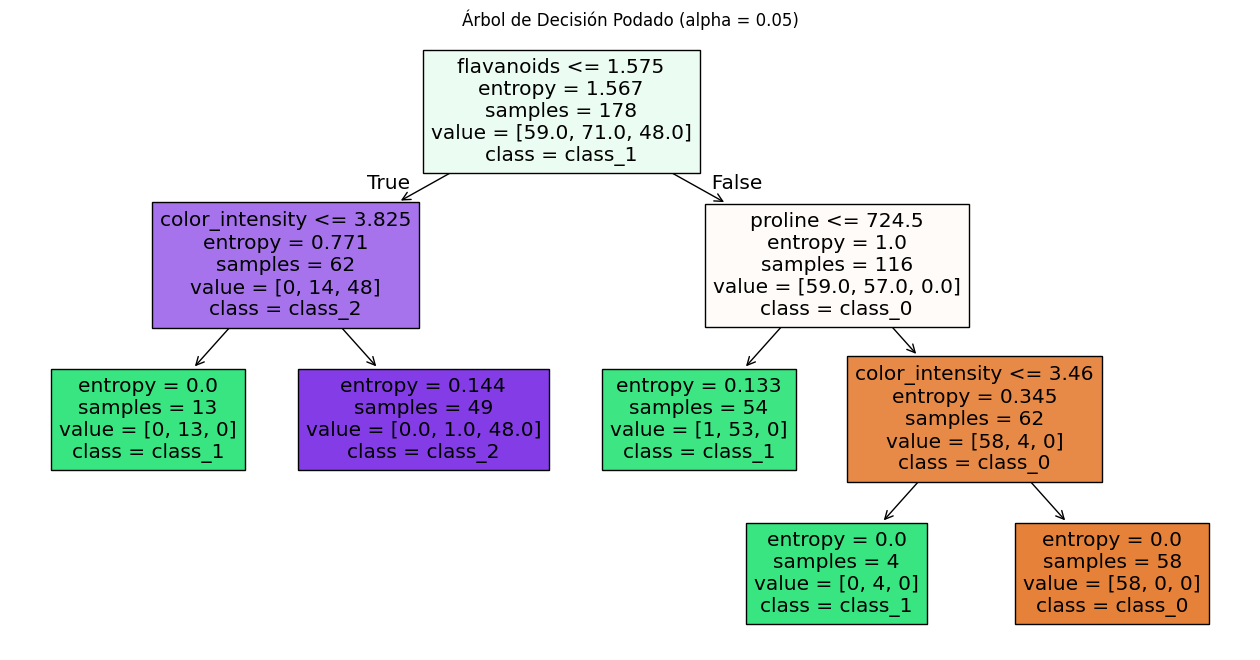

Número total de nodos: 9
Número total de hojas: 5
Top 3 características más importantes:
- flavanoids: 0.4350
- proline: 0.3302
- color_intensity: 0.2348

La muestra fue clasificada como clase: class_0

Costo-complejidad teórica del árbol podado: 0.3299


In [26]:
# entrenamos el árbol con poda (ccp_alpha = 0.05)
alpha = 0.05
clf_podado = DecisionTreeClassifier(criterion="entropy", ccp_alpha=alpha)
clf_podado.fit(X, y)

# graficamos el árbol podado
plt.figure(figsize=(16, 8))
plot_tree(clf_podado, filled=True, feature_names=feature_names, class_names=target_names)
plt.title("Árbol de Decisión Podado (alpha = 0.05)")
plt.show()

# obtenemos la cantidad de nodos y hojas
n_nodos = clf_podado.tree_.node_count
n_hojas = sum(clf_podado.tree_.children_left == -1)
print(f"Número total de nodos: {n_nodos}")
print(f"Número total de hojas: {n_hojas}")

# mostramos las 3 características más importantes
importances = clf_podado.feature_importances_
top_indices = np.argsort(importances)[::-1][:3]

print("Top 3 características más importantes:")
for idx in top_indices:
    print(f"- {feature_names[idx]}: {importances[idx]:.4f}")

# Clasificamos la muestra dada
prediccion = clf_podado.predict(muestra)
print(f"\nLa muestra fue clasificada como clase: {target_names[prediccion[0]]}")

#===============================================================#
# Calculamos el costo-complejidad del árbol

# Obtenemos el árbol
tree = clf_podado.tree_
n_samples = tree.n_node_samples[0]  # total de muestras en la raíz

# vemos cuales son nodos hoja
hojas = tree.children_left == -1

# iteramos sobre todos los nodos y vamos calculando la suma ponderada (n_m / n_samples) * H_Qm
suma_impurezas_ponderadas = 0
for i in range(tree.node_count):
    # si el nodo es hoja realizamos el cálculo
    if hojas[i]:
        n_m = tree.n_node_samples[i]
        H_Qm = tree.impurity[i]
        suma_impurezas_ponderadas += (n_m / n_samples) * H_Qm


costo_complejidad = suma_impurezas_ponderadas + alpha * n_hojas
print(f"\nCosto-complejidad teórica del árbol podado: {costo_complejidad:.4f}")



Se puede ver que la profundidad del árbol con poda es menor:

- En el árbol sin poda tenemos: 15 nodos, 8 hojas.
- En el árbol podado tenemos: 9 nodos, 5 hojas.

También se observa que las características más importantes siguen siendo las mismas, lo que nos indica que las decisiones más relevantes del árbol se mantienen consistentes, incluso después de aplicar poda.

En ambos casos la muestra se clasifica como `class_0`, por lo que la poda no afectó la clasificación.

Podemos decir como conclusión general que la poda logró reducir la complejidad del árbol (menos nodos y hojas) sin sacrificar precisión ni cambiar la clasificación de la muestra y reduciendo el riesgo de overfitting.

---

# **Bosques Aleatorios(Random Forest)**

Los bosques aleatorios (Random Forest) son un método que consiste en múltiples árboles de decisión, diseñado para reducir el problema de overfitting característico de los árboles individuales. Si bien existen técnicas como la poda o los criterios de parada que ayudan a mitigarlo, no siempre son suficientes. Por eso, se introduce el método Bagging (Bootstrap Aggregating), que consiste en entrenar múltiples modelos sobre subconjuntos del conjunto de datos original y combinar sus salidas, mediante promedio (para regresión) o votación mayoritaria (para clasificación).

Se busca promediar ya que se mantiene la esperanza y reduce la varianza en muestras i.i.d:

$$
  \mathbb{E}\left[ \frac{1}{B} \sum_{b=1}^B Z_b \right] = \mu, \quad
  \text{var} \left( \frac{1}{B} \sum_{b=1}^B Z_b \right) = \frac{\sigma^2}{B}
$$

En clasificación, si se piensan etiquetas en codificación *one-hot*, promediar para luego elegir el máximo equivale a elegir la respuesta mayoritaria.

Como se mencionó previamente, se busca reducir el problema de overfitting de los árboles individuales, para ello lo que se desea es entrenar varios algoritmos de manera que sean variados. Para ello se toman 2 decisiones:

- En lugar de utilizar todos los $d_x$ features, para asegurar la variedad en los árboles, en cada nodo se eligen $\sqrt{d_x}$ features.

- Se generan $B$ conjuntos de datos del mismo tamaño que el dataset original ($n$), para ello se utiliza la técnica llamada Bootstrap, es decir, para cada uno de estos conjuntos, se eligen al azar $n$ datos del conjunto con reposición y se arma cada conjunto Bootstrap, de manera que la probabilidad de que un dato no esté en el conjunto es $\approx 37\%$. 

---

### **Implementación**

Para implementar el bosque aleatorio, creamos una clase `RandomForest` que recibe como parámetros, la cantidad de árboles a utilizar (`n_trees`) y el criterio de impurezas (`criterion`).

Luego, para la etapa de entrenamiento se define el método `fit` que recibe los datos de entrada `X` y las etiquetas `y`. Dentro del método lo que se hace es:

1) Se genera el conjunto `X_sample` e `y_sample`  para entrenar un árbol utilizando la técnica de Bootstrap mencionada previamente. Para armar el conjunto utilizamos el método `resample` pasando como argumento los datos `X` e `y` y ademas se setea el parámetro `replace=True` para imponer la reposición. 

2) Generar un nuevo árbol a partir de la clase `DecisionTreeClassifier` de la librería `sklearn` pasando como parámetros el criterio a utilizar (en nuestro caso vamos a utilizar la entropía) y para implementar el hecho de que para cada nodo se eligen $\sqrt{d_x}$ features, se setea el parámetro `max_features = 'sqrt'`.

3) Se entrena el árbol utilizando los conjuntos generados con el Bootstrap y se guarda el árbol en una lista de árboles.


En la etapa de testeo, lo que se hace es obtener las predicciones de todos los árboles generados en la etapa de entrenamiento y con `mode` obtenemos la clase que más se repitió en esas predicciones (votación mayoritaria).


In [ ]:
#generamos la clase
class RandomForest:
    def __init__(self, n_trees=30, criterion='entropy'):
        self.n_trees = n_trees
        self.criterion = criterion
        self.trees = []

    def fit(self, X, y):

        #iteramos sobre la cantidad de árboles
        for i in range(self.n_trees):
            # Bootstrap sample
            X_sample, y_sample = resample(X, y, replace=True)

            # creamos y entrenamos el árbol
            tree = DecisionTreeClassifier(criterion=self.criterion, max_features='sqrt')
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        # obtenemos las predicciones de cada árbol
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        
        # obtenemos la clase que más se repite (votación mayoritaria)
        y_pred, _ = mode(all_preds, axis=0, keepdims=False)
        return y_pred


# Creamos y entrenamos el Random Forest
rf = RandomForest()
rf.fit(X, y)

pred = rf.predict(muestra)
print(f"\nLa muestra fue clasificada como clase: {target_names[pred[0]]}")



La muestra fue clasificada como clase: class_0


Se observa que la misma muestra con Random Forest, en algunas ejecuciones es clasificada como `class_0` y en otras como `class_1`, esto se debe a la aletoriedad que estamos introduciendo en el algoritmo (como se mencionó previamente) al armar los subconjuntos Bootstrap y en la elección de las características en cada división.